# 18 November 2020 WDC Prototype Lab Measurements

Analysis of data collected in the PSU lab on 11/18/2020 with WDC Rev. 1 SN5. Baselines between channels were manually equalized before taking these measurements. The DAC setting for channel 0 was 1000 and the DAC setting for channel 1 was 964.

In [1]:
import numpy as np
import math
import matplotlib.colors as mplcolors
from matplotlib import pyplot as plt

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

clock_freq = 245.76  # MHz
wfm_dir = '../software/waveforms'

# Analysis of Pure Noise Waveforms

The following waveforms were acquired with software triggers. The WDC input was connected to the DG535 -> inverting transformer -> resistive combinator -> 20 dB attenuator chain, but the DG535 was off.

In [2]:
def load_data(fname, wfm_dir=wfm_dir):
    with np.load(f'{wfm_dir}/{fname}', allow_pickle=True) as f:
        return f['a']

def plot_wfm(wfm, ax, colors=colors, xlim=None):
    chan_num = wfm["chan_num"]

    if chan_num == "combined":
        title = "interleaved"
        samps = wfm["samples"]
        n_samps = len(samps)
        ax.plot(np.arange(len(samps)) / 2, samps, "k--")
        ax.plot(samps[::2], "o", color=colors[1])
        ax.plot(np.arange(int(n_samps / 2)) + 0.5, samps[1::2], "o", color=colors[0])
        ax.set_xlabel('sample number')
    else:
        color = colors[chan_num]
        title = f"channel {chan_num}"
        ax.plot(wfm["samples"], "-", color=color)

    mean = np.average(wfm["samples"])
    std = np.std(wfm["samples"])
    ax.set_title(f"{title}, mean: {mean:.2f}, std: {std:.2f}")

    ax.set_ylabel("ADU")
    if xlim is not None:
        ax.set_xlim(*xlim)

def build_combined_wfm(wfms):
    n_samples = len(wfms[0]['samples'])
    
    combined_samples = np.empty(2 * n_samples, np.uint16)
    combined_samples[::2] = wfms[1]["samples"]
    combined_samples[1::2] = wfms[0]["samples"]
    combined_wfm = dict(chan_num="combined", samples=combined_samples)
    
    return combined_wfm
    
def plot_wfms(wfms, n_samples=None, xlim=None):
    if n_samples is None:
        n_samples = len(wfms[0]['samples'])
        
    wfms = [wfm.copy() for wfm in wfms]
    for wfm in wfms:
        wfm['samples'] = wfm['samples'][:n_samples]
        
    combined_wfm = build_combined_wfm(wfms)
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
    plt.subplots_adjust(hspace=0.3)
    for chan, ax in zip([0, 1, "combined"], axes.flat):
        wfm = wfms[chan] if chan != 'combined' else combined_wfm
        plot_wfm(wfm, ax, xlim=xlim)

In [3]:
noise_data = load_data('sw_trig_noise_11_18_2020-16_57_51.npz')

### Example noise trace: 

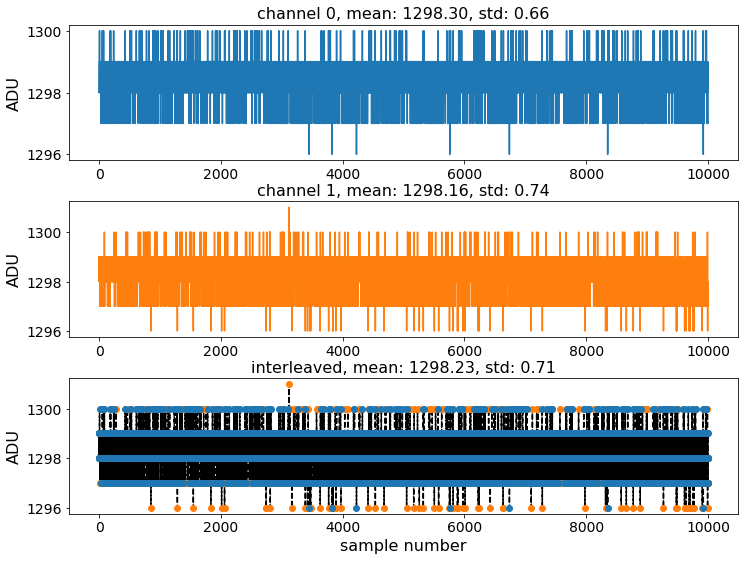

In [4]:
plot_wfms(noise_data[0])

In [5]:
def min_sample(wfms):
    return min(wfm['samples'].min() for wfm in wfms)

def max_sample(wfms):
    return max(wfm['samples'].max() for wfm in wfms)

def process_noise_event(wfms, noise_hist_bins):
    ''' for each noise trace, histogram the samples and take an FFT'''
    combined = build_combined_wfm(wfms)
    
    results = {}
    for chan in 0, 1, 'combined':
        wfm = wfms[chan] if chan != 'combined' else combined
        hist, bins = np.histogram(wfm['samples'], bins=noise_hist_bins)
        fft = np.abs(np.fft.fft(wfm['samples']))
        
        results[chan] = dict(hist=hist, fft=fft)
    
    return results

In [6]:
%%time
min_noise_sample = min(map(min_sample, noise_data))
max_noise_sample = max(map(max_sample, noise_data))
noise_hist_bins = np.arange(min_noise_sample-5, max_noise_sample+6)

noise_results = [process_noise_event(event, noise_hist_bins) for event in noise_data]

CPU times: user 2.03 s, sys: 281 ms, total: 2.31 s
Wall time: 2.31 s


In [7]:
hist_sums = {}
for result in noise_results:
    for chan in result:
        result_hist = result[chan]['hist']
        if chan not in hist_sums:
            hist_sums[chan] = result_hist.copy()
        else:
            hist_sums[chan] += result_hist

fft_sums = {}
for result in noise_results:
    for chan in result:
        result_fft = result[chan]['fft']
        if chan not in fft_sums:
            fft_sums[chan] = result_fft.copy()
        else:
            fft_sums[chan] += result_fft

In [8]:
def make_noise_hist_plot():
    fig, ax = plt.subplots(figsize=(12, 3))
    
    for chan in 0, 1:
        mean = np.average(noise_hist_bins[:-1], weights=hist_sums[chan])
        var = np.average((noise_hist_bins[:-1]-mean)**2, weights=hist_sums[chan])
        std = np.sqrt(var)
        ax.step(noise_hist_bins[:-1], hist_sums[chan], where='post', label=f'channel {chan}\n mean: {mean:.2f}, std: {std:.2f}')

    ax.set_xlim(1290, 1305)
    ax.set_yscale('log')

    ax.legend(loc='upper left')
    ax.set_xlabel('ADU')
    ax.set_ylabel('n samples')

    ax.set_title('baseline noise')
    fig.savefig('baseline_noise.png')
    
def make_noise_fft_plot():
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
    axiter = axes.flat

    plt.subplots_adjust(hspace=0.3)

    for (chan, fft_sum), color in zip(fft_sums.items(), colors):
        ax = next(axiter)

        period = 1 / clock_freq

        samples_per_wfm = len(noise_data[0][0]['samples'])

        if chan == "combined":
            n_samples = 2 * samples_per_wfm
            period /= 2
            label='combined'
        else:
            n_samples = samples_per_wfm
            label=f'channel {chan}'

        fft_freq = np.fft.fftfreq(n_samples, period)
        ax.plot(fft_freq[fft_freq > 0], fft_sum[fft_freq > 0] / len(noise_data), color=color)

        ax.set_title(label)
        ax.set_ylabel('average FFT mag')
        if chan == 'combined':
            ax.set_xlabel('f (MHz)')

    fig.savefig('baseline_fft.png', bbox='tight')

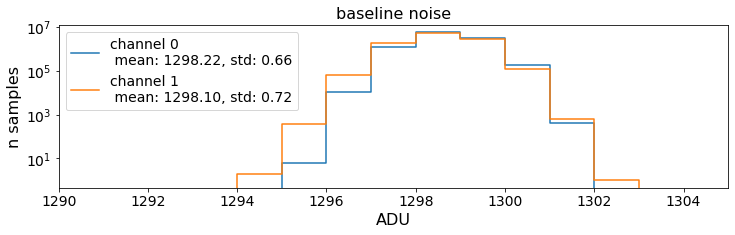

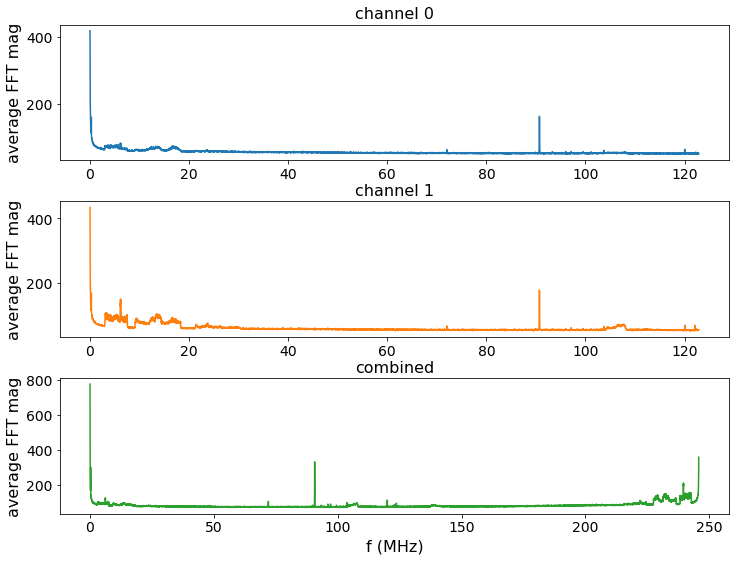

In [9]:
make_noise_hist_plot()
plt.show()
make_noise_fft_plot()

# Sine Wave Analysis

Examine sine waves; measure phase difference between channel 0 and channel 1

In [10]:
sine_data = load_data('sinewave_11_18_2020-19_15_31.npz')

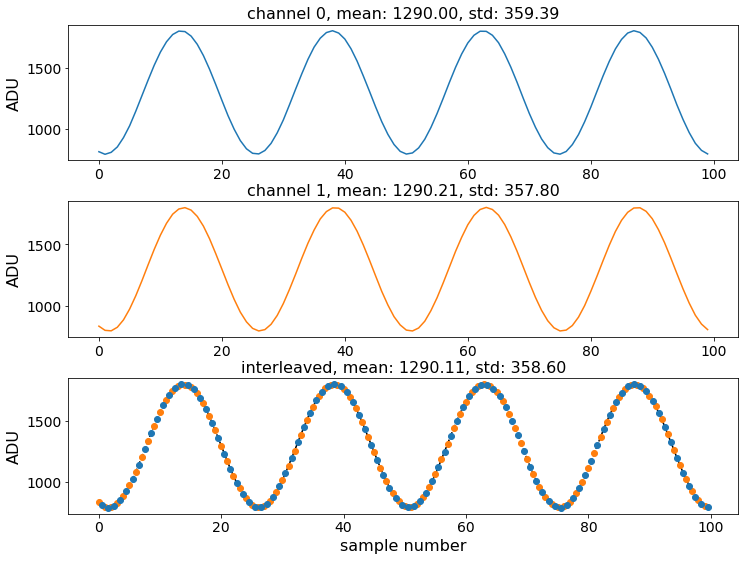

In [11]:
plot_wfms(sine_data[0], n_samples=100)

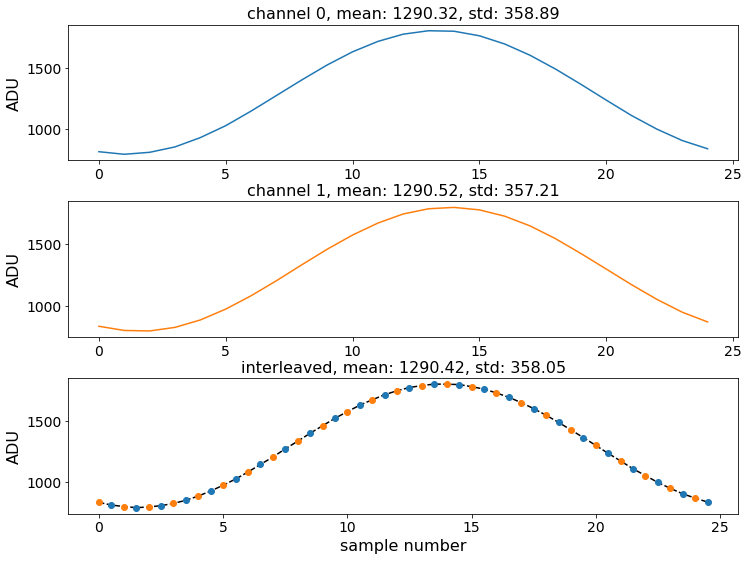

In [12]:
plot_wfms(sine_data[0], n_samples=25)

In [13]:
from scipy.optimize import curve_fit

### Fit waveforms to $A \cos\left [ 2\pi f (t - t_0) \right ] + P$. Fit parameters are $A$, $f$, $t_0$, and $P$.

In [14]:
def sinusoid(t, A, f, t0, P):
    f = f / clock_freq
    return A * np.cos(2 * math.pi * f * (t - t0)) + P

def fit_sinusoid(wfm, freq_guess):
    samps = wfm['samples']
    P_guess = np.average(samps)
    A_guess = samps.max() - P_guess
    
    # find first local maximum
    prev_samp = samps[0]
    t0_guess = 0
    for i, samp in enumerate(samps[1:-1], 1):
        next_samp = samps[i+1]
        if prev_samp < samp and next_samp < samp:
            t0_guess = i
            break
        else:
            prev_samp = samp
            
    return curve_fit(sinusoid, np.arange(len(samps)), samps, p0=[A_guess, freq_guess, t0_guess, P_guess])

In [15]:
%%time
_ = fit_sinusoid(sine_data[0][0], 10)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 12.3 ms


In [16]:
def plot_sinusoid_fit(wfm, f_guess, n_samples, ax, color):
    fit_res, _ = fit_sinusoid(wfm, f_guess)
    
    ax.plot(wfm['samples'][:n_samples], 'o', color=color, label='data')
    t = np.linspace(0, n_samples, 10000)
    fit_parnames = ['A', 'f', 't_0', 'P']
    fit_str = 'fit:'
    for name, par in zip(fit_parnames, fit_res):
        fit_str += f'\n${name}$: {par:.2f}'

    ax.plot(t, sinusoid(t, *fit_res), '--', color=color, label=fit_str)
    
    ax.legend()

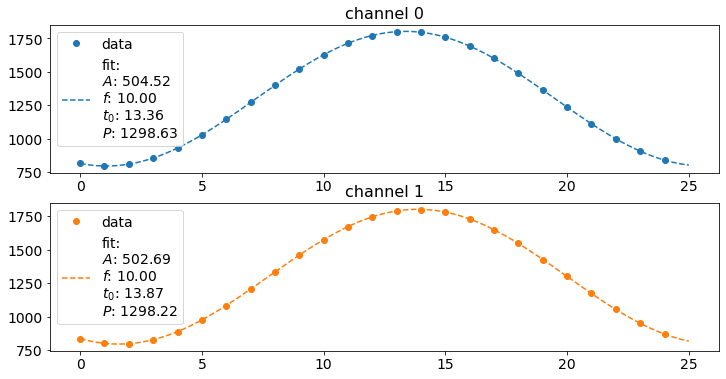

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
axiter = axes.flat
for ch in 0, 1: 
    ax = next(axiter)
    
    plot_sinusoid_fit(sine_data[0][ch], 10, 25, ax, colors[ch])
    ax.set_title(f'channel {ch}')

If the two channels were sampling exactly out of phase, we would expect the difference in the $t_0$ parameter between them to be exactly 0.5. It's close. Let's fit all the waveforms from this dataset and histogram the fit results. This also might tell us something about the relative gain differences between channels.

In [18]:
%%time
fit_res = []
for event in sine_data:
    fit_res.append([fit_sinusoid(wfm, 10) for wfm in event])

CPU times: user 11.1 s, sys: 15.6 ms, total: 11.1 s
Wall time: 11.1 s


In [19]:
def plot_par(fit_res, par_num, par_name, ax):
    par_vals = []
    for ch in 0, 1:
        par_vals.append([r[ch][0][par_num] for r in fit_res])
    
    min_val = min(min(ps) for ps in par_vals)
    max_val = max(max(ps) for ps in par_vals)
    
    r = max_val - min_val
    bins = np.linspace(min_val - 0.15*r, max_val + 0.15*r, 100)
    
    for ch in 0, 1:
        hist, _ = np.histogram(par_vals[ch], bins=bins)
        ax.step(bins[:-1], hist, label=f'channel {ch}')
    
    ax.set_xlabel(par_name)
    ax.set_ylabel('n fits')
    ax.legend()
    
def plot_fit_res(fit_res, freq):
    ''' histogram fit frequencies, fit amplitudes, and difference in t0 between channels'''    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    axiter = axes.flat
    plot_par(fit_res, 0, '$A$', next(axiter))
    plot_par(fit_res, 1, '$f$ / MHz', next(axiter))
    ax = next(axiter)
    plot_par(fit_res, 3, '$P$', ax)
    # x axis getting crowded...
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax = next(axiter)
    delta_t0s = np.array([r[1][0][2] - r[0][0][2] for r in fit_res])
    # only keep fits where the fitter stayed near the initial guess
    delta_t0s = delta_t0s[np.abs(delta_t0s) < 1]

    delta_t0_hist, bins = np.histogram(delta_t0s, bins=100)
    ax.step(bins[:-1], delta_t0_hist, label='measured')
    ax.set_xlabel('$\Delta t_0$')
    mean = np.average(delta_t0s)
    ax.axvline(mean, linestyle='--', color=colors[0], label=f'mean: {mean:.3f}')
    ax.axvline(0.5, linestyle='--', color='black', label='ideal')
    ax.legend()
    
    fig.suptitle(f'{freq} MHz Sine Wave Fit\n$A \cos\\left [ 2\\pi f (t - t_0) \\right ] + P$', fontsize=24, y=0.95)

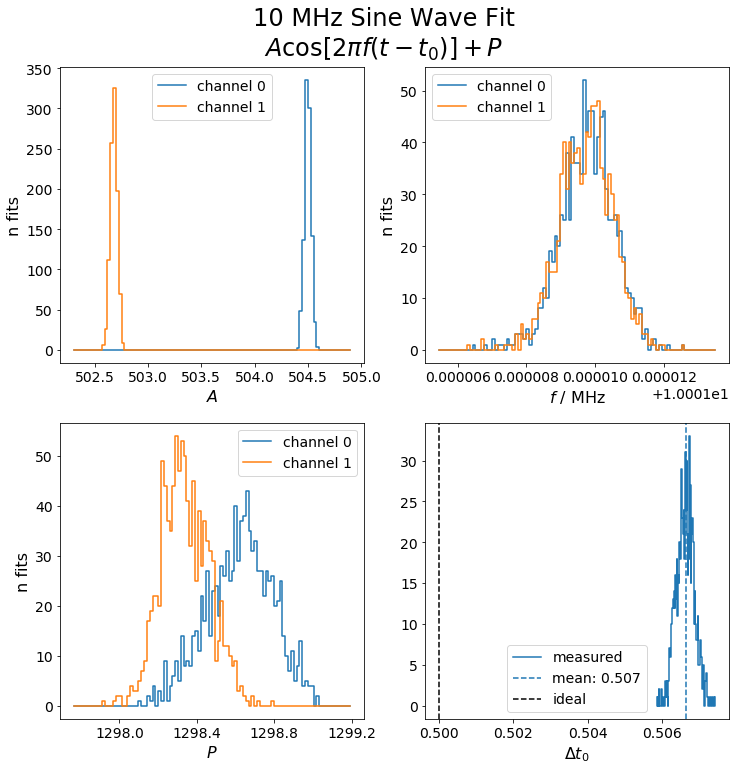

In [20]:
plot_fit_res(fit_res, 10)

### The above plot suggests that the gains of channel 0 and channel 1 are equal to within half a percent or so. Additionally, the timing offset between channels is not exactly 0.5 clock ticks, but rather closer to 0.507 clock ticks. The difference between the ideal offset, and the measured offset 0.007 clock ticks, corresponds to 28 ps. This probably an acceptably small number. However, one could apply a correction if desired.

### Let's check if we draw the same conclusions from the 50 MHz sine wave measurements.

# 50 MHz Sine Wave

In [21]:
sine_data_50 = load_data('sinewave_50MHz_11_18_2020-19_44_24.npz')

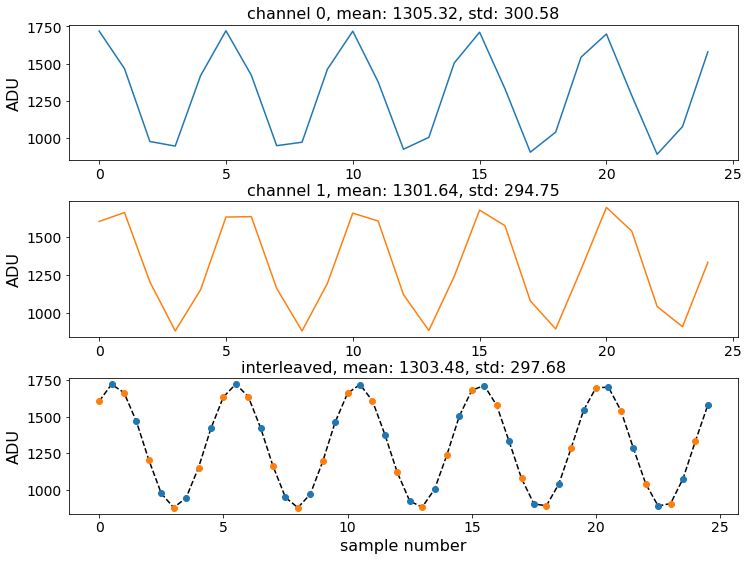

In [22]:
plot_wfms(sine_data_50[0], n_samples=25)

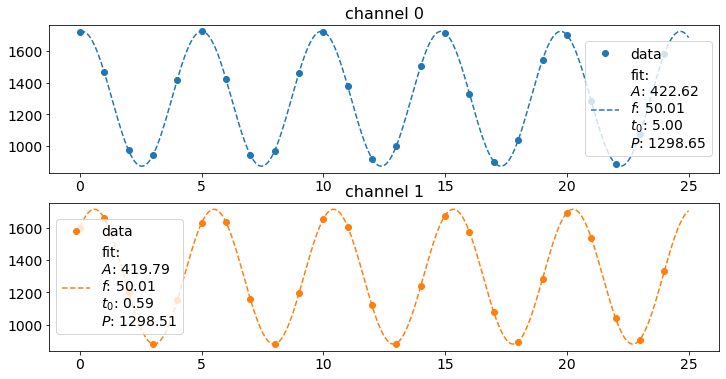

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
axiter = axes.flat
for ch in 0, 1: 
    ax = next(axiter)
    
    plot_sinusoid_fit(sine_data_50[0][ch], 50, 25, ax, colors[ch])
    ax.set_title(f'channel {ch}')

In [24]:
%%time
fit_res_50 = []
for event in sine_data_50:
    fit_res_50.append([fit_sinusoid(wfm, 50) for wfm in event])

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 14.3 s


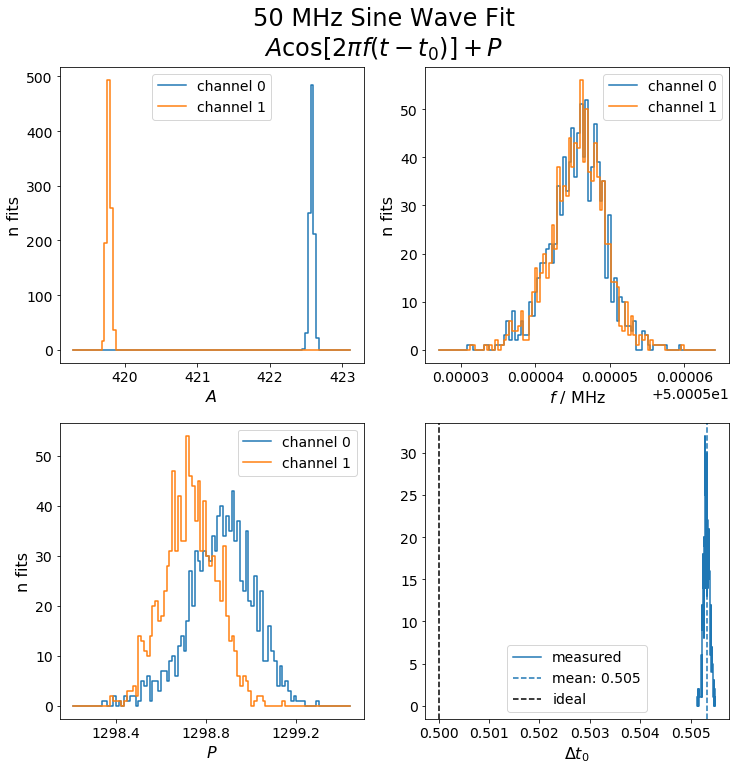

In [25]:
plot_fit_res(fit_res_50, 50)

### The conclusions are quite similar. The gains are still different by about 0.5%, and now we measure a 20 ps difference from the ideal sampling offset rather than a 28 ps difference. It is likely that the small differences between the 10 MHz and 50 MHz measurements are not significant, but a more thorough analysis is required to say for sure.

# Single DG535 pulse data

This data was acquired with the same setup as described in the WDC Bring Up document for double pulse measurements, but the second pulse was delayed until it was outside of the acquisition window. Because of the threshold triggering scheme, a small fraction of the acquired waveforms will be the second pulse rather than the first. I estimate approximately 1 in 1000.

In [26]:
single_pulse_data = load_data('template_pulses_11_18_2020-18_28_56.npz')

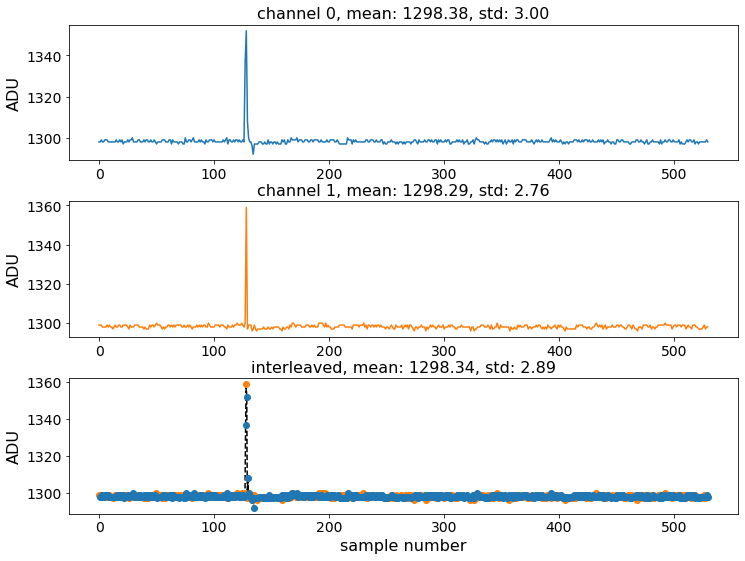

In [27]:
plot_wfms(single_pulse_data[0])

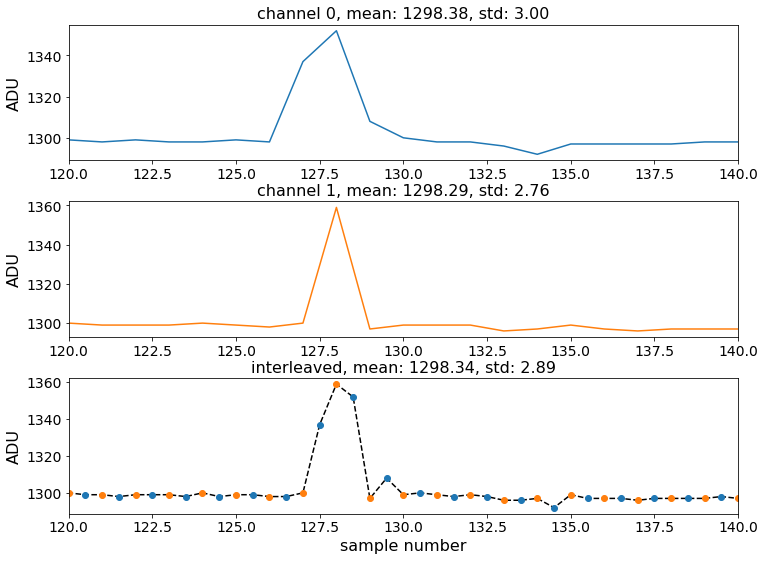

In [28]:
plot_wfms(single_pulse_data[0], xlim=(120, 140))

Task: build a template for each channel and for the interleaved waveforms. Then, compare them.

In [29]:
def get_pseudo_time(wfm):
    s = wfm['samples']
    
    i_max = np.argmax(s)
    
    s0 = s[i_max]
    s_p = s[i_max + 1]
    s_m = s[i_max - 1]
    
    denom = s0 - s_p
    num = s0 - s_m
    if denom == 0:
        if num == 0:
            return 0.5
        else:
            return 1
    
    p_time = 2 / math.pi * math.atan((s0 - s_m) / (s0 - s_p))
    
    return p_time

In [30]:
%%time
template_wfms = []
for event in single_pulse_data:
    wfms = list(event)
    wfms += [build_combined_wfm(wfms)]
    for wfm in wfms:
        wfm['ptime'] = get_pseudo_time(wfm)
        
    template_wfms.append(wfms)

CPU times: user 578 ms, sys: 31.2 ms, total: 609 ms
Wall time: 591 ms


### Build pseudotime hists for each channel

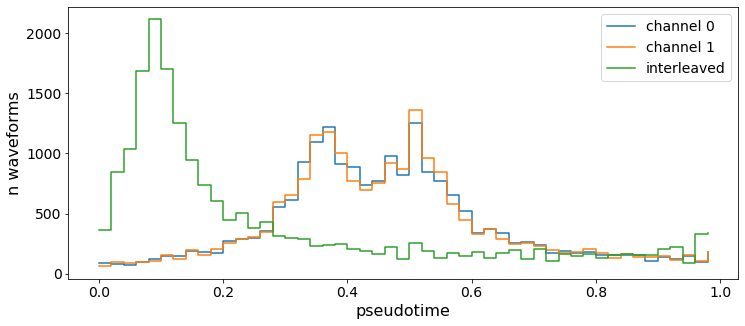

In [31]:
ptime_vals = [np.array([wfms[i]['ptime'] for wfms in template_wfms]) for i in range(3)]
ptime_hist_bins = np.linspace(0, 1, 51)

hists = []
for ptimes in ptime_vals:
    hists.append(np.histogram(ptimes, ptime_hist_bins)[0])
    
fig, ax = plt.subplots(figsize=(12, 5))
for hist, label in zip(hists, ['channel 0', 'channel 1', 'interleaved']):
    ax.step(ptime_hist_bins[:-1], hist, where='post', label=label)
    
ax.set_xlabel('pseudotime')
ax.set_ylabel('n waveforms')
ax.legend()

### Build map to "real time"

In [32]:
from scipy.interpolate import UnivariateSpline

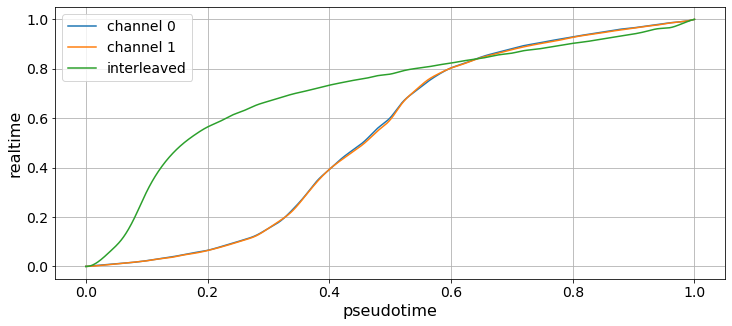

In [33]:
rt_maps = []
for hist in hists:
    cumsum = np.cumsum(hist) / hist.sum()
    x = ptime_hist_bins
    y = np.hstack((np.zeros(1), cumsum))
    rt_maps.append(UnivariateSpline(x, y, s=0))

fig, ax = plt.subplots(figsize=(12, 5))
t = np.linspace(0, 1, 1000)
for rt_map, label in zip(rt_maps, ['channel 0', 'channel 1', 'interleaved']):
    ax.plot(t, rt_map(t), label=label)
ax.set_xlabel('pseudotime')
ax.set_ylabel('realtime')
ax.legend()
ax.grid()

### Record realtime for each pulse

In [34]:
for event in template_wfms:
    for wfm, rt_map in zip(event, rt_maps):
        wfm['rtime'] = rt_map(wfm['ptime'])

### Make "real time" histograms; they should be flat (by construction)

(0, 750)

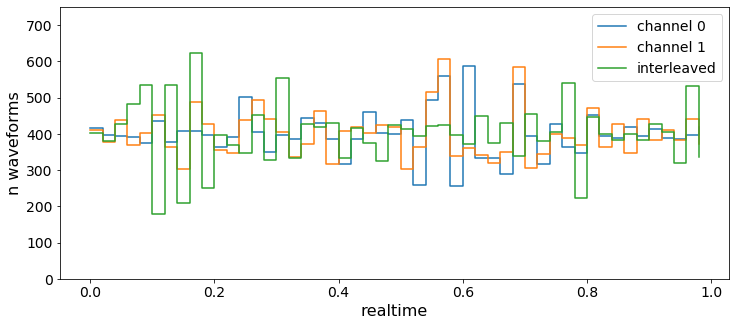

In [35]:
rtime_vals = [np.array([wfms[i]['rtime'] for wfms in template_wfms]) for i in range(3)]

rt_hists = []
for rtimes in rtime_vals:
    rt_hists.append(np.histogram(rtimes, ptime_hist_bins)[0])
    
fig, ax = plt.subplots(figsize=(12, 5))
for hist, label in zip(rt_hists, ['channel 0', 'channel 1', 'interleaved']):
    ax.step(ptime_hist_bins[:-1], hist, where='post', label=label)
    
ax.set_xlabel('realtime')
ax.set_ylabel('n waveforms')
ax.legend()
ax.set_ylim(0, 750)

### Build the pulse templates

In [36]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [37]:
def get_baseline_corrected(wfm, first_n=100, n_to_keep=400):
    samples = wfm['samples']
    return samples[:n_to_keep] - np.average(samples[:first_n])


def get_x_profile(h2d_out, errorbars=False):
    y_axis = h2d_out[2]
    
    y_centers = 0.5*(y_axis[1:] + y_axis[:-1])
    bin_contents = h2d_out[0]
    prof_vals = []
    prof_errs = []
    for hist_col in bin_contents:
        if hist_col.sum() == 0:
            prof_vals.append(0)
            prof_errs.append(0)
        else:
            prof_vals.append(np.average(y_centers, weights=hist_col))
            prof_var = np.average((y_centers - prof_vals[-1])**2, weights=hist_col)
            prof_errs.append(np.sqrt(prof_var))
    
    if not errorbars:
        return np.array(prof_vals)
    else:
        return np.array(prof_vals), np.array(prof_errs)

def build_template_spline(h2d_out):
    y_vals = get_x_profile(h2d_out)
    
    x_edges = h2d_out[1]
    x_centers = 0.5 * (x_edges[1:] + x_edges[:-1])
    
    return UnivariateSpline(x_centers, y_vals, s=0)
  

def build_pulse_template(wfms, n_time_slices=11, n_before_peak=100, y_range=(-20, 80), n_y_bins=121):
    '''returns 2d "fuzzy" template and template spline'''
    samples = [[] for _ in range(n_time_slices)]
    
    for wfm in wfms:
        ind = int(wfm['rtime']*n_time_slices)
        if ind == n_time_slices:
            ind -= 1
        samples[ind].append(get_baseline_corrected(wfm))
    
    flat_x_data = []
    flat_y_data = []
    for i, phase_wfms in enumerate(samples):
        n_samples = len(phase_wfms[0])
        
        r_time = (i + 0.5) / n_time_slices
        shift = 1 - r_time - 0.5
        
        xs = np.arange(n_samples) + shift
        for wfm in phase_wfms:
            # shift based on peak index
            flat_x_data.extend(xs - np.argmax(wfm))
            flat_y_data.extend(wfm)
    
    n_samples = len(samples[0][0])
    
    x_bins = np.linspace(-0.5, n_samples - 0.5, n_time_slices*n_samples + 1) - n_before_peak
    y_bins = np.linspace(*y_range, n_y_bins)
    
    h2d_out = np.histogram2d(flat_x_data, flat_y_data, bins=[x_bins, y_bins])
    
    hist_data = h2d_out[0].T
  
    return h2d_out, build_template_spline(h2d_out)


def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar


def plot_template(h2d_out, name, ax, xlim=(-5, 15)):
    h, x, y = h2d_out
    im = ax.pcolormesh(x, y, h.T, cmap='Spectral', 
                       rasterized=True, linewidth=0,
                       norm=mplcolors.LogNorm(vmin=0.1, vmax=h.max()*1.1))
    colorbar(im)
    ax.set_xlabel('sample num')
    ax.set_ylabel('ADU')
    ax.set_title(name)
    ax.set_xlim(*xlim)

In [38]:
# data per channel
ch0_wfms, ch1_wfms, interleaved_wfms = zip(*template_wfms)

In [39]:
%%time
# build templates for each channel
templates = []
for wfms in ch0_wfms, ch1_wfms, interleaved_wfms:
    templates.append(build_pulse_template(wfms, 22))

CPU times: user 9.95 s, sys: 2.78 s, total: 12.7 s
Wall time: 12.7 s


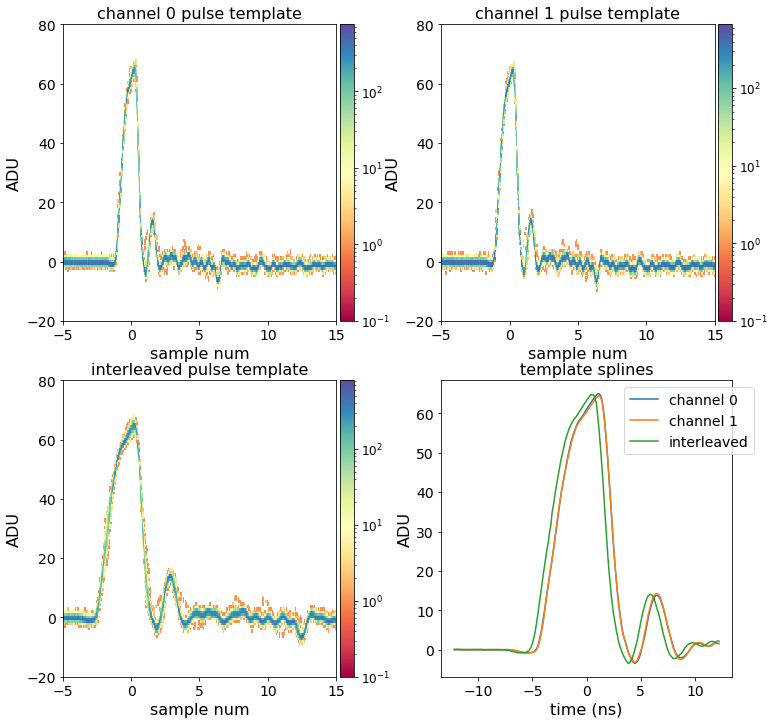

In [40]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.3)
axiter = axes.flat

for template, name in zip(templates, ['channel 0', 'channel 1', 'interleaved']):
    plot_template(template[0], f'{name} pulse template', next(axiter))
    
ts = np.linspace(-3, 3, 1000)
ts_in_ns = ts * 1000 / clock_freq
ax = next(axiter)
for template, name in zip(templates, ['channel 0', 'channel 1', 'interleaved']):
    spline = template[1]
    spline_arg = ts if name != 'interleaved' else 2*ts
    ax.plot(ts_in_ns, spline(spline_arg), label=name)
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('ADU')
    ax.set_title('template splines')
    ax.legend(bbox_to_anchor=(1.1, 1))

### The templates look very similar in channel 0 and channel 1, and we are able to build a clean template using the interleaved waveforms. The interleaving works well for sampling this narrow pulse.

# Single pulse template fitting

### Fit waveforms to $f(t) = s\cdot T(t - t_0) + P$, where $T$ is the pulse template.  

Just use scipy curve fit for now; nothing fancy

In [41]:
def get_template_fit_func(templ):
    def f(t, s, t0, P):
        return s*templ(t - t0) + P
    return f


def template_fit(wfm, template, fit_range=(-5, 5), n_baseline=100):
    fit_func = get_template_fit_func(template)
    
    samples = wfm['samples']
    sample_times = np.arange(len(samples))
    
    peak = np.argmax(samples)
    fit_range = (sample_times >= peak + fit_range[0]) & (sample_times <= peak + fit_range[1])
    
    baseline_guess = np.average(samples[:100])
    
    fit_res = curve_fit(fit_func, sample_times[fit_range], samples[fit_range], [1, peak, baseline_guess])
    
    return fit_res, fit_range


def template_fit_event(wfms, fit_range=(-5, 5), n_baseline=100):
    return [template_fit(wfm, templ[1], fit_range, n_baseline) for (wfm, templ) in zip(wfms, templates)]



def plot_template_fit(wfm, templ_spline, fit_out, color, ax):
    fit_p, fit_range = fit_out
    
    samps = wfm['samples'][fit_range]
    sample_nums = np.arange(len(wfm['samples']))[fit_range]
    t_pts = np.linspace(sample_nums[0] - 1, sample_nums[-1] + 1, 1000)
    if wfm['chan_num'] == 'combined':
        title = 'interleaved'
        plot_t_pts = t_pts / 2
        plot_s_pts = sample_nums / 2
    else:
        title = f'channel {wfm["chan_num"]}'
        plot_t_pts = t_pts
        plot_s_pts = sample_nums
    
    ax.plot(plot_s_pts, samps, 'o', color=color, label='samples')  
    ax.plot(plot_t_pts, get_template_fit_func(templ_spline)(t_pts, *fit_p[0]), '--', color=color, label='template fit')
    
    ax.set_title(title)
    ax.set_ylabel('ADU')
    ax.legend()
#     ax.set_xlabel('sample num')

### Example template fits

Text(0.5, 0, 't (clock ticks)')

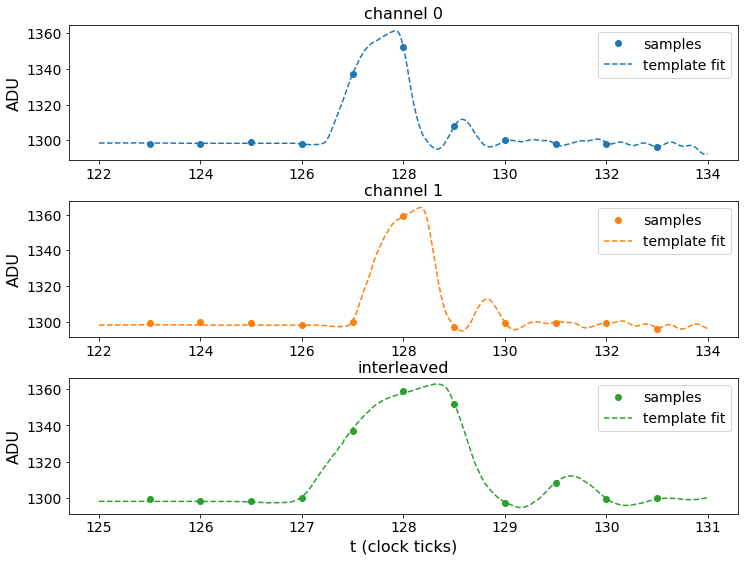

In [42]:
event_num = 0
first_event_res = template_fit_event(template_wfms[event_num])
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3)
for wfm, fit_out, templ, color, ax in zip(template_wfms[event_num], first_event_res, templates, colors, axes.flat):
    plot_template_fit(wfm, templ[1], fit_out, color, ax)
ax.set_xlabel('t (clock ticks)')

Text(0.5, 0, 't (clock ticks)')

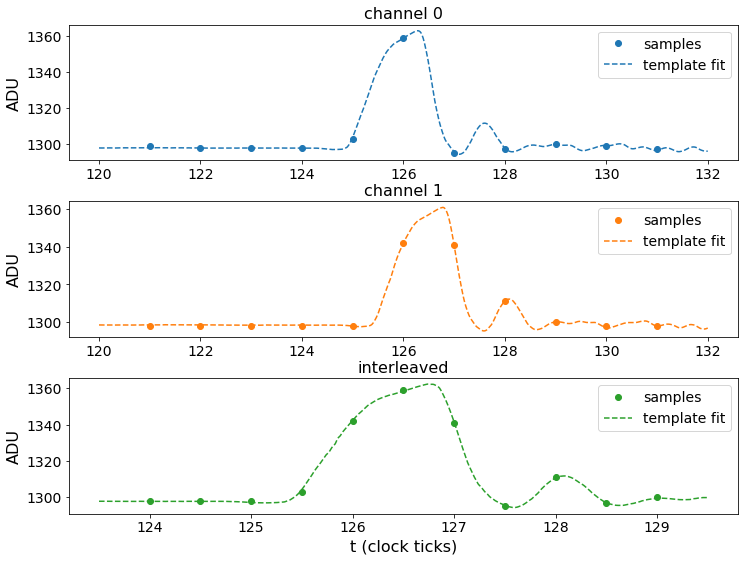

In [43]:
event_num = 1052
first_event_res = template_fit_event(template_wfms[event_num])
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3)
for wfm, fit_out, templ, color, ax in zip(template_wfms[event_num], first_event_res, templates, colors, axes.flat):
    plot_template_fit(wfm, templ[1], fit_out, color, ax)
ax.set_xlabel('t (clock ticks)')

### Fit all the single pulse waveforms

In [44]:
%%time
n_to_fit = len(template_wfms)
single_pulse_fit_res = [template_fit_event(event) for event in template_wfms[:n_to_fit]]

CPU times: user 42.2 s, sys: 0 ns, total: 42.2 s
Wall time: 42.3 s


### Difference in reconstructed times between channels 0 and 1

In [45]:
# too many indices; [chan_num][fit_res][fit_p][time index]
delta_t = np.array([res[1][0][0][1] - res[0][0][0][1] for res in single_pulse_fit_res])

19963

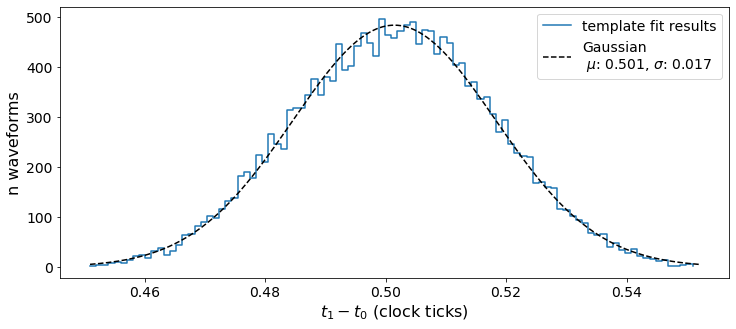

In [46]:
fig, ax = plt.subplots(figsize=(12, 5))
std = delta_t.std()
mean = delta_t.mean()

bins = np.linspace(mean - 3*std, mean + 3*std, 100)
hist, bins = np.histogram(delta_t, bins)

ax.step(bins[:-1], hist, where='post', label='template fit results')

gaus_norm = len(delta_t)*(bins[1] - bins[0]) / math.sqrt(2*math.pi) / std
gaus_xs = np.linspace(bins[0], bins[-1], 1000)

gaus_label = f'Gaussian\n $\mu$: {mean:.3f}, $\sigma$: {std:.3f}'

ax.plot(gaus_xs, gaus_norm*np.exp(-(gaus_xs - mean)**2/2/std**2), 'k--', label=gaus_label)

ax.set_xlabel('$t_{1} - t_{0}$ (clock ticks)')
ax.set_ylabel('n waveforms')
ax.legend()
hist.sum()

### The time difference between channels is normally distributed with a width of 0.017 c.t., or 70 ps. This includes the contribution from two channels, so the per-channel timing resolution could be as good as 70 ps / $\sqrt{2}$. However, there are likely correlated contributions to the timing resolution between channels. For now, this measurement suggests the intrinsic timing resolution of the digitizer electronics is at least as good as 70 ps.

### Check for phase biases by looking at $\Delta t$ versus time in channel 1 mod 1 c.t. 

In [47]:
t0 = np.array([res[0][0][0][1] for res in single_pulse_fit_res])
t0_phase = np.remainder(t0, 1)
x_bins = np.linspace(0, 1, 50)
y_bins = np.linspace(0.4, 0.6, 50)
hist2d, x_bins, y_bins = np.histogram2d(t0_phase, delta_t, bins=(x_bins, y_bins))

Text(0, 0.5, '$t_1$ - $t_0$')

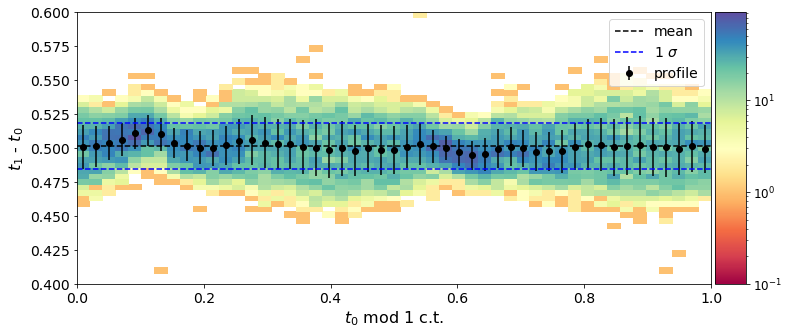

In [48]:
fig, ax = plt.subplots(figsize=(12, 5))
im = ax.pcolormesh(x_bins, y_bins, hist2d.T, cmap='Spectral', 
                   rasterized=True, linewidth=0,
                   norm=mplcolors.LogNorm(vmin=0.1, vmax=hist2d.max()*1.1))
colorbar(im)
x_profile, prof_err = get_x_profile((hist2d, x_bins, y_bins), errorbars = True)
ax.errorbar(0.5*(x_bins[1:] + x_bins[:-1]), x_profile, yerr=prof_err, fmt='ko', label='profile')
ax.axhline(mean, color='black', linestyle='--', label='mean')
ax.axhline(mean + std, color='blue', linestyle='--', label=r'$1~\sigma$')
ax.axhline(mean - std, color='blue', linestyle='--')
ax.legend()
ax.set_xlabel(r'$t_0$ mod 1 c.t.')
ax.set_ylabel(r'$t_1$ - $t_0$')

### Overall, the time reconstruction appears to be well behaved. There are some phases where the mean shifts slightly and the spread decreases. There is no phase bin where the mean time shifts by more than 70 ps. 